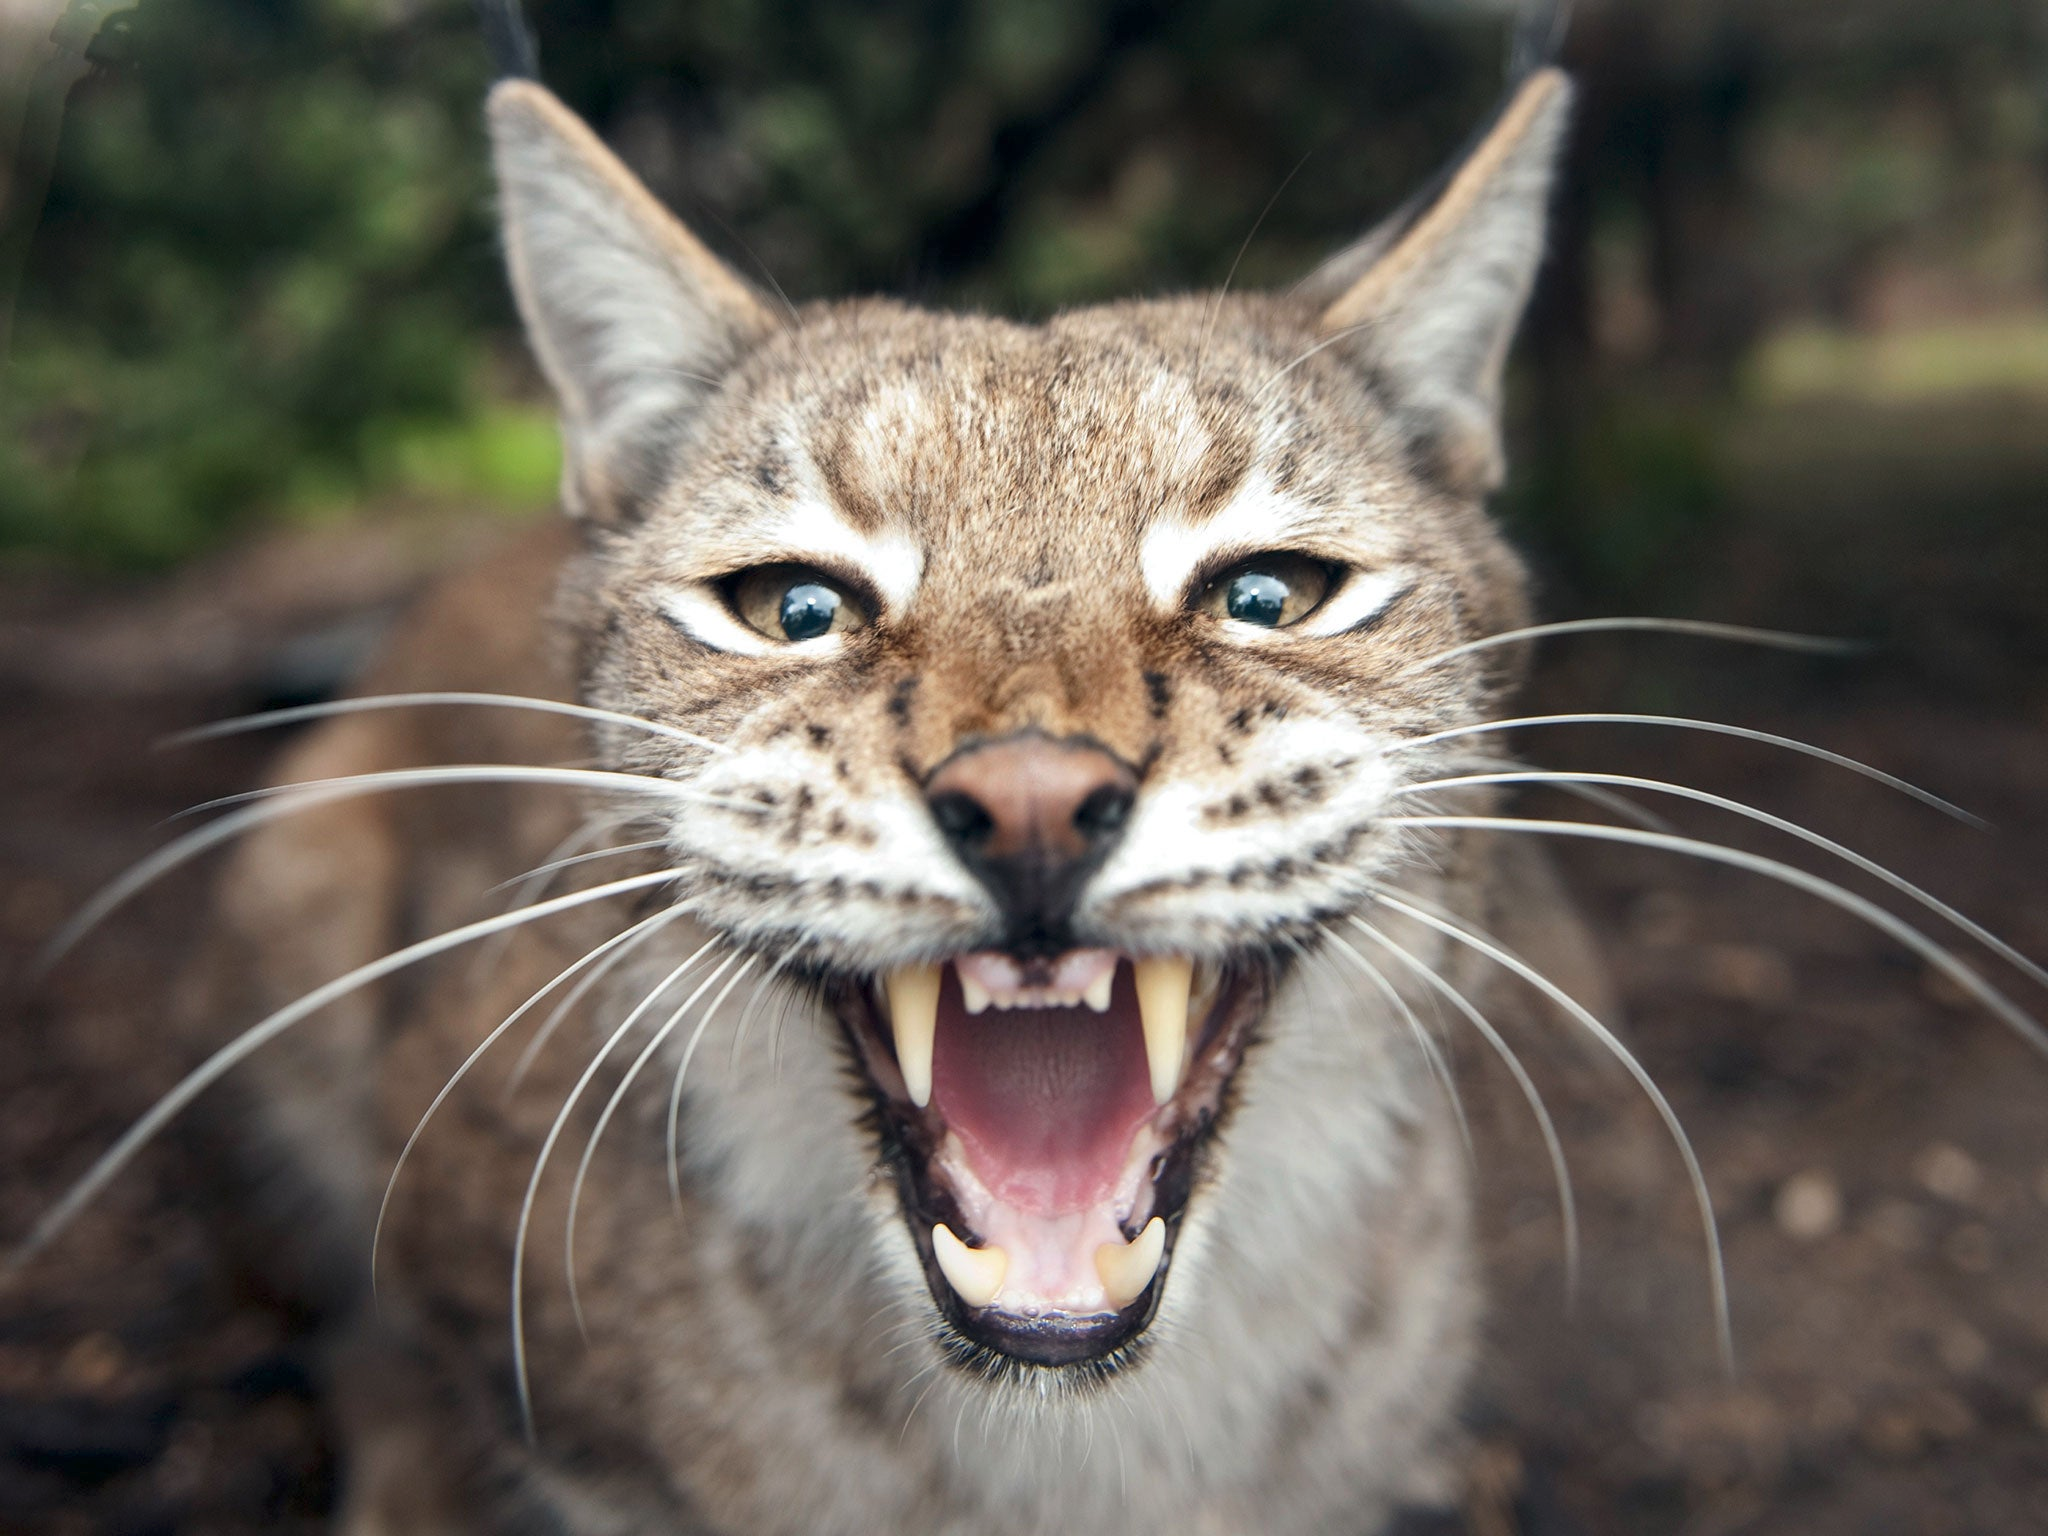

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates

import seaborn as sns
import matplotlib.style as style
# style.use('ggplot')

import pmdarima as pmd
pmd.__version__  #should be version 1.5.2

from pmdarima.datasets import load_lynx

plt.rcParams['figure.figsize'] = (15,5)

The Lynx dataset records the number of skins of predators (lynx) that were collected over many years by the Hudson’s Bay Company (1821 - 1934). It’s commonly used for time-series benchmarking (Brockwell and Davis - 1991).

For this excercise you must imagine that you are alive in 1934, that you are not concerned about hunting large animals for personal gain, and most strangely you have access to a modern computer...

The Hudson's Bay Company wishes you to make a forecast for the number of animal skins it will trade over next 10 years so it can plan its human resources. You must:

    Make an ARIMA model that predicts the number of skins for the next 20 years following the data set.
    Evaluate the estimated accuracy of your model using a suitable method
    Compare you model to a naive model


# Importing data

In [3]:
big_cats = load_lynx(as_series=True)

#there's no datetimeindex from the bundled dataset. So let's add one.
big_cats.index= pd.date_range('1821', periods=len(big_cats), freq='Y')

In [4]:
def ts_train_test_split(data, split_date):
    '''
    Split time series into training and test data
    
    Parameters:
    -------
    data - pd.DataFrame - time series data.  Index expected as datatimeindex
    split_date - the date on which to split the time series
    
    Returns:
    --------
    tuple (len=2) 
    0. pandas.DataFrame - training dataset
    1. pandas.DataFrame - test dataset
    '''
    train = data.loc[data.index < split_date]
    test = data.loc[data.index >= split_date]
    return train, test

In [28]:
from pmdarima.arima import ARIMA
from pmdarima.model_selection import RollingForecastCV, cross_val_score

def mean_absolute_percentage_error(y_true, y_pred): 
    '''
    MAPE

    Parameters:
    --------
    y_true -- np.array actual observations from time series
    y_pred -- the predictions to evaluate

    Returns:
    -------
    float, scalar value representing the MAPE (0-100)
    '''
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def ARIMA_model_cv(arima_model,train,horizon,step):  
    cv = RollingForecastCV(h=horizon, step=step)
    cv_results = cross_val_score(arima_model, train_log, cv=cv, scoring=mean_absolute_percentage_error)
    return pd.DataFrame(cv_results).dropna().describe()

# Preparing data

We split train and test. Test should be the duration we want, i.e. 10 yrars.

In [5]:
train, test =ts_train_test_split(big_cats,'1925')

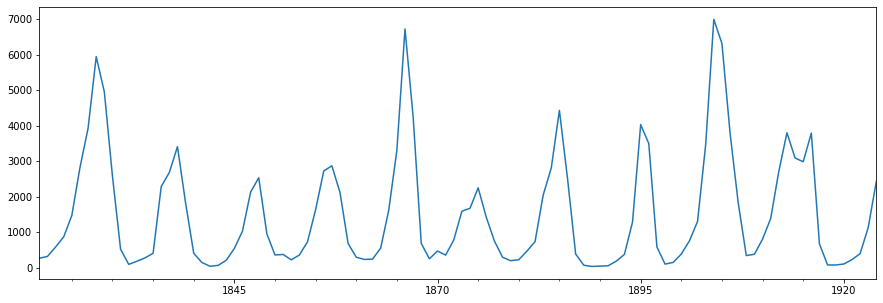

In [6]:
train.plot()

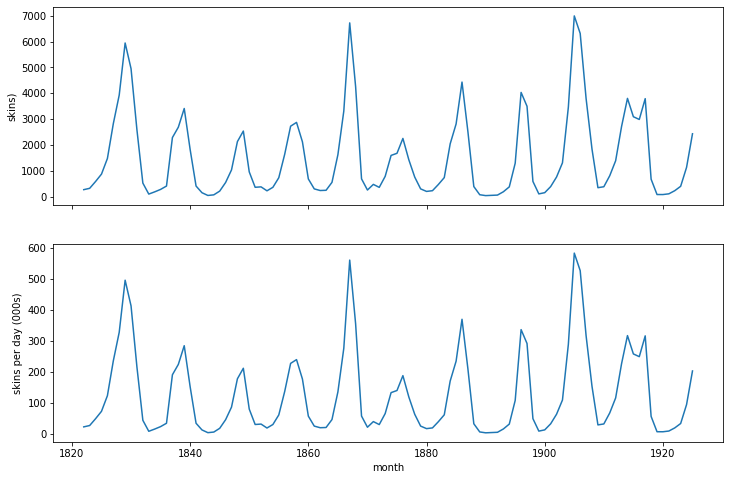

In [7]:
train_adj = train / 12
test_adj = train / 12

#plot the adjusted and unadjusted series
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

axes[0].figsize = (12, 10)

axes[0].plot(train)
axes[0].set(ylabel='skins)');

axes[1].plot(train_adj)
axes[1].set(xlabel='month', ylabel='skins per day (000s)');

#Seems useless. Such a transforamtion only makes sense when looking at monthly values, since number of days vary

# Testing seasonality

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [9]:
sd_result = seasonal_decompose(train, model='multiplicative', period=9)

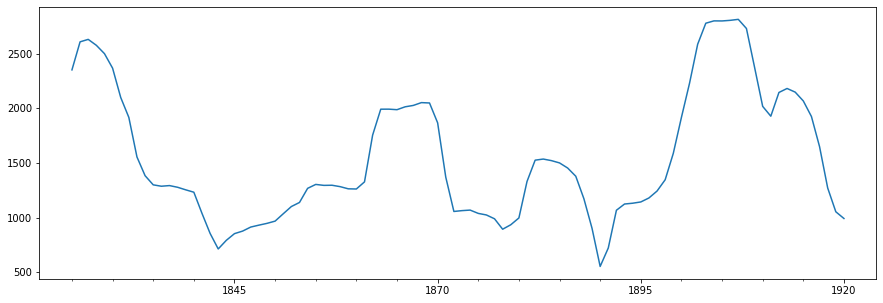

In [10]:
sd_result.trend.plot()

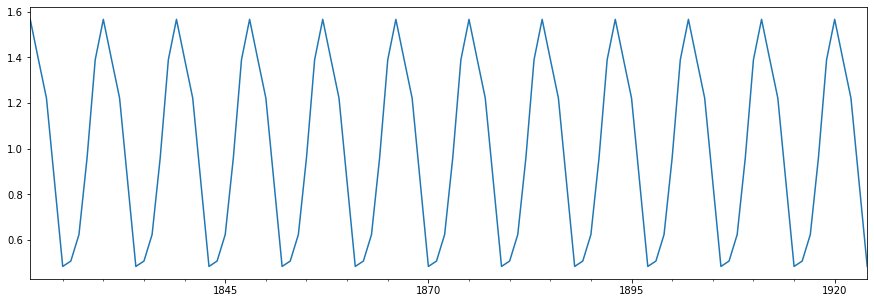

In [11]:
sd_result.seasonal.plot()

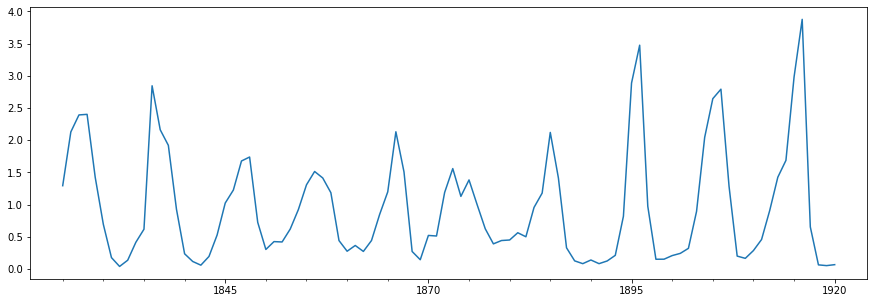

In [12]:
sd_result.resid.plot()

It appears that there is seasonality but no clear trend. In this case no need to try naive models.

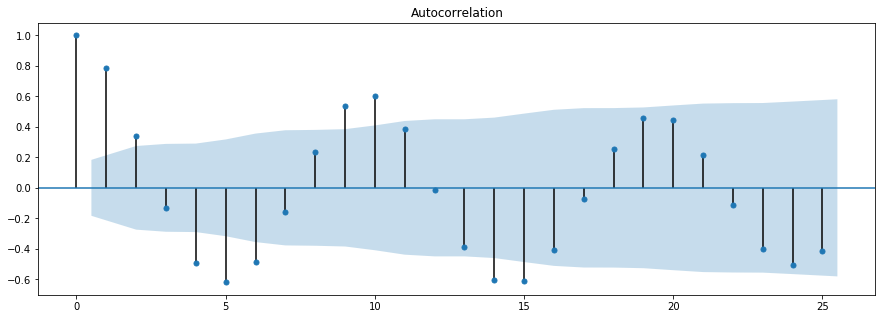

In [72]:
# Check for seasonality
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train, lags=25);

# ARIMA 

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [13]:
from pmdarima.arima import auto_arima

In [14]:
train_log = np.log(train)

Period is one year, season seems to be 10times period. Therefore m is 10 time 1 is 10.

In [15]:
arima_model = auto_arima(train_log, seasonal=True, suppress_warnings=True, m=9)

In [19]:
period=10

insample_predictions = arima_model.predict_in_sample()

mean_absolute_percentage_error(train_log[period:], insample_predictions[period:])



6.5248495861456215

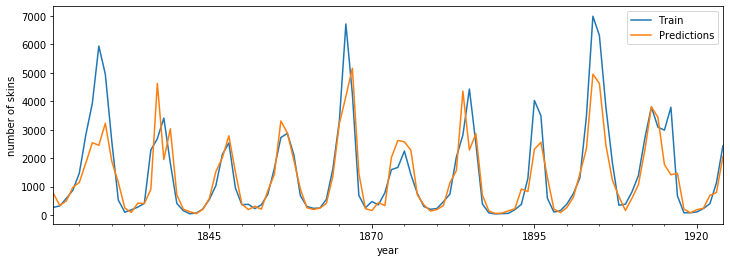

In [21]:
insample_predictions = pd.DataFrame(np.exp(insample_predictions), index=train.index)
ax = train.plot(figsize=(12,4))
insample_predictions.plot(ax=ax)
ax.set(xlabel='year', ylabel='number of skins');
ax.legend(['Train', 'Predictions'])

In [22]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  104
Model:               SARIMAX(3, 0, 3)   Log Likelihood                 -71.823
Date:                Thu, 12 Mar 2020   AIC                            159.647
Time:                        12:07:28   BIC                            180.802
Sample:                             0   HQIC                           168.218
                                - 104                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.6860      0.355      4.755      0.000       0.991       2.381
ar.L1          1.9572      0.135     14.481      0.000       1.692       2.222
ar.L2         -1.5963      0.213     -7.481      0.000      -2.015      -1.178
ar.L3          0.3849      0.131      2.931      0.003       0.128       0.642
ma.L1         -0.8232      0.110     -7.503      0.000      -1.038      -0.608
ma.L2          0.0556      0.135      0.412      0.680      -0.209       0.320
ma.L3          0.5669      0.102      5.581      0.000       0.368       0.766
sigma2         0.2209      0.038      5.815      0.000       0.146       0.295
===================================================================================
Ljung-Box (Q):                       34.87   Jarque-Bera (JB):                 1.48
Prob(Q):                              0.70   Prob(JB):                         0.48
Heteroskedasticity (H):               1.24   Skew:                            -0.05
Prob(H) (two-sided):                  0.53   Kurtosis:                         2.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

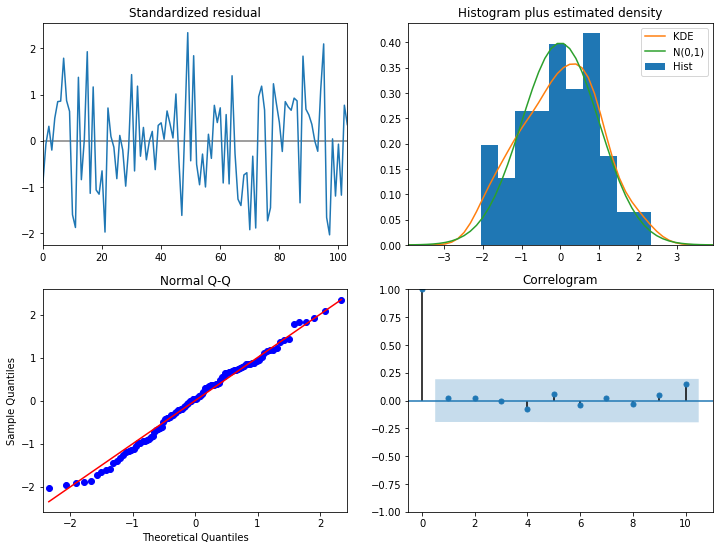

In [23]:
arima_model.plot_diagnostics(figsize=(12,9));

Standardized residual = (observed count – expected count) / √expected count<br><br>
<b>Top left:</b> The residual errors seem to fluctuate around a mean of zero and have a uniform variance.<br>
<b>Top Right:</b> The density plot suggest normal distribution with mean zero.<br>
<b>Bottom left:</b> All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.<br>
<b>Bottom Right:</b> The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.<br>

In [86]:
results = ARIMA_model_cv(arima_model,train,10,10)
results

0
count   6.000000
mean   12.763232
std     8.971799
min     5.733140
25%     7.239459
50%     8.704027
75%    15.428570
max    29.016841

In [33]:
horizon = 10

# fit arima model to whole time series
big_cats_log = np.log(big_cats)
arima_model.fit(big_cats_log)

#make predictions for following 12 periods
final_forecast, cis = arima_model.predict(horizon, return_conf_int=True, alpha=0.05)

#### need to back transform the log
final_forecast = np.exp(final_forecast)
cis = np.exp(cis)

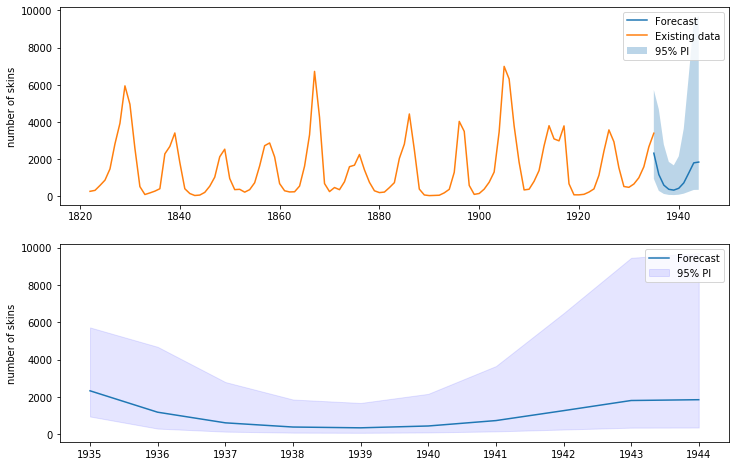

In [34]:
#create an datetime index for the forecast horizon
forecast_index = pd.date_range(start='1935', periods=horizon, freq='YS')

#plot the model with 90% predictions intervals
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(pd.Series(final_forecast, index=forecast_index));
axes[0].plot(big_cats)


axes[0].set(ylabel='number of skins');

limits = pd.DataFrame(cis, index=forecast_index, columns=['lower', 'upper'])
axes[0].fill_between(forecast_index, limits['lower'], limits['upper'], 
                  alpha=.3, 
                  label='95% PI')

axes[0].legend([ 'Forecast','Existing data', '95% PI']);



axes[1].plot(pd.Series(final_forecast, index=forecast_index));
axes[1].set(ylabel='number of skins');

axes[1].fill_between(forecast_index, limits['lower'], limits['upper'], 
                  alpha=.1, 
                  label='95% PI', color='blue')

axes[1].legend(['Forecast', '95% PI']);

# GridSearching

In [233]:
train.dropna(inplace=True)

In [265]:
import itertools
from itertools import combinations
from sklearn.model_selection import train_test_split

train.dropna(inplace=True)

def grid_search(train):
    
#     l=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    l=[0,1,2,3]
    i=0
#     for comb3 in combinations(l,3):
#         for comb4 in combinations(l,4):
#             model = ARIMA(order=comb3, seasonal_order=comb4, suppress_warnings = True)
#             results_cv = ARIMA_model_cv(model,train,10,5)
#             results.loc[i]=[comb3[0]] + [comb3[1]] + [comb3[2]] + [comb4[0]] + [comb4[1]] + [comb4[2]] + [comb4[3]] + \
#              [float(results_cv.iloc[0].values)] + [float(results_cv.iloc[1].values)] + [float(results_cv.iloc[2].values)] + \
#              [float(results_cv.iloc[3].values)] + [float(results_cv.iloc[4].values)] + [float(results_cv.iloc[5].values)]+ \
#              [float(results_cv.iloc[6].values)] + [float(results_cv.iloc[7].values)]
#             i+=1        
    
    for comb3 in combinations(l,3):
        for comb4 in combinations(l,2):
            comb4 = (0,) + comb4 + (12,)
            model = ARIMA(order=comb3, seasonal_order=comb4, suppress_warnings = True)
            results_cv = ARIMA_model_cv(model,train,10,5)
            results.loc[i]=[comb3[0]] + [comb3[1]] + [comb3[2]] + [comb4[0]] + [comb4[1]] + [comb4[2]] + [comb4[3]] + \
             [float(results_cv.iloc[0].values)] + [float(results_cv.iloc[1].values)] + [float(results_cv.iloc[2].values)] + \
             [float(results_cv.iloc[3].values)] + [float(results_cv.iloc[4].values)] + [float(results_cv.iloc[5].values)]+ \
             [float(results_cv.iloc[6].values)] + [float(results_cv.iloc[7].values)]
            i+=1        
    
#     comb4 = (0, 0, 0, 0)
    
#     for comb3 in combinations(l,3):
#         model = ARIMA(order=comb3, seasonal_order=comb4, suppress_warnings = True)
#         results_cv = ARIMA_model_cv(model,train,10,5)
#         results.loc[i]=[comb3[0]] + [comb3[1]] + [comb3[2]] + [comb4[0]] + [comb4[1]] + [comb4[2]] + [comb4[3]] + \
#          [float(results_cv.iloc[0].values)] + [float(results_cv.iloc[1].values)] + [float(results_cv.iloc[2].values)] + \
#          [float(results_cv.iloc[3].values)] + [float(results_cv.iloc[4].values)] + [float(results_cv.iloc[5].values)]+ \
#          [float(results_cv.iloc[6].values)] + [float(results_cv.iloc[7].values)]
#         i+=1        
#     return results

p=
	order of the autoregressive part;<br>
d=
	degree of first differencing involved;<br>
q=
	order of the moving average part. <br>

In [273]:
# results=pd.DataFrame(columns=['p','d','q','P','D','Q','s','count','mean','std','min','25%','50%','75%','max'])
# grid_search(train)
# results

In [267]:
results

p    d    q    P    D    Q     s  count       mean        std        min  \
0  0.0  1.0  2.0  0.0  0.0  1.0  12.0    6.0  26.859866  16.241493  13.279092   
1  0.0  1.0  2.0  0.0  0.0  2.0  12.0    6.0  23.569001  14.090214  10.850718   
2  0.0  1.0  2.0  0.0  0.0  3.0  12.0    6.0  21.990295  11.985439  11.454370   
3  0.0  1.0  2.0  0.0  1.0  2.0  12.0    6.0  30.624940   9.110098  18.296849   
4  0.0  1.0  2.0  0.0  1.0  3.0  12.0    6.0  20.008167   9.841928   8.719528   

         25%        50%        75%        max  
0  17.584780  22.180405  27.589684  58.073612  
1  14.443757  21.139747  24.940065  49.865193  
2  12.760121  19.176666  26.546515  42.509663  
3  27.085215  28.517871  35.015290  44.628292  
4  12.105783  19.845386  26.020146  34.034391

In [253]:
model = ARIMA(order=(3,0,0), suppress_warnings = True)
ARIMA_model_cv(model,train,10,5)

0
count   6.000000
mean   13.655858
std     8.499732
min     7.038350
25%     7.643408
50%    10.019858
75%    17.231801
max    28.370044

In [36]:
def ARIMA_model_cv(arima_model,train,horizon,step):  
    cv = RollingForecastCV(h=horizon, step=10)
    cv_results = cross_val_score(arima_model, train_log, cv=cv, scoring=mean_absolute_percentage_error, verbose=-1)
    return pd.DataFrame(cv_results).dropna().describe()

# Naive model

## Very naive

In [38]:
from forecast.baseline import Naive1, SNaive

period = 9

naive1 = Naive1()
naive1.fit(train)
insample_predictions = naive1.fittedvalues


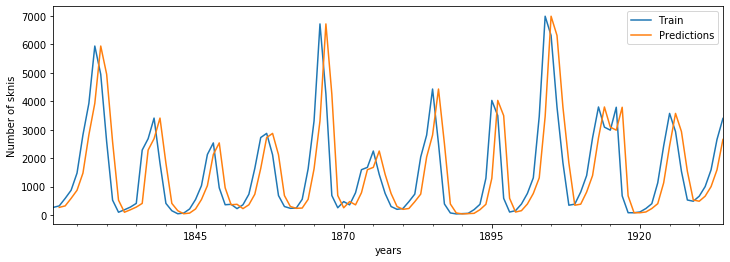

In [39]:
ax = train.plot(figsize=(12,4))
insample_predictions.plot(ax=ax)
ax.set(xlabel='years', ylabel='Number of sknis');
ax.legend(['Train', 'Predictions']);

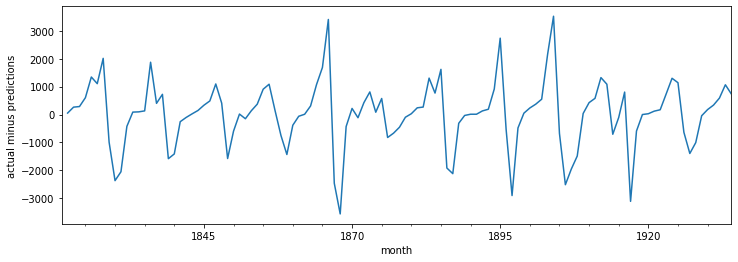

In [40]:
ax = naive1.resid.plot(figsize=(12,4))
ax.set(xlabel='month', ylabel='actual minus predictions');

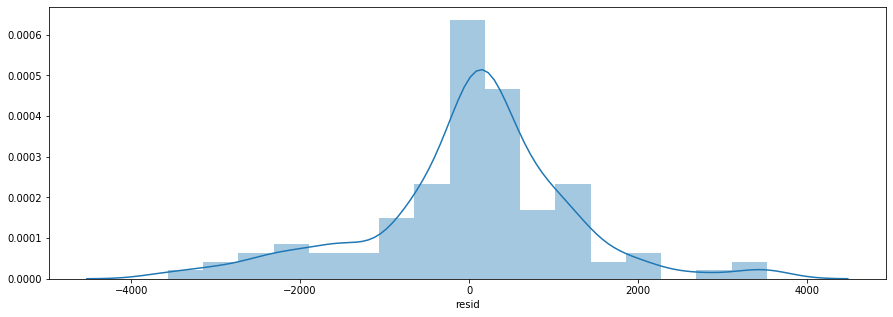

In [41]:
sns.distplot(naive1.resid.dropna())

In [42]:
mean_absolute_percentage_error(big_cats[period:], insample_predictions[period:])

100.06693941693452

Cross validation

In [68]:
#i've written a function to help with the cv of the baseline
from forecast.model_selection import time_series_cv

#it requires the data to be split into training and validation.
train, test = ts_train_test_split(big_cats_log, '1960-01-01')

trainCV, valCV = train.iloc[:len(train)//3], train.iloc[len(train)//3:]

naive1 = Naive1()

cv_scores = time_series_cv(naive1, 
                           error_func=mean_absolute_percentage_error,
                           train=trainCV,
                           val=valCV,
                           horizons=[12],
                           step=6)

In [69]:
cv_scores = pd.DataFrame(cv_scores)
cv_scores.describe()

0
count  11.000000
mean   22.006291
std    11.258802
min    11.032945
25%    15.716505
50%    17.511726
75%    24.429235
max    47.522833

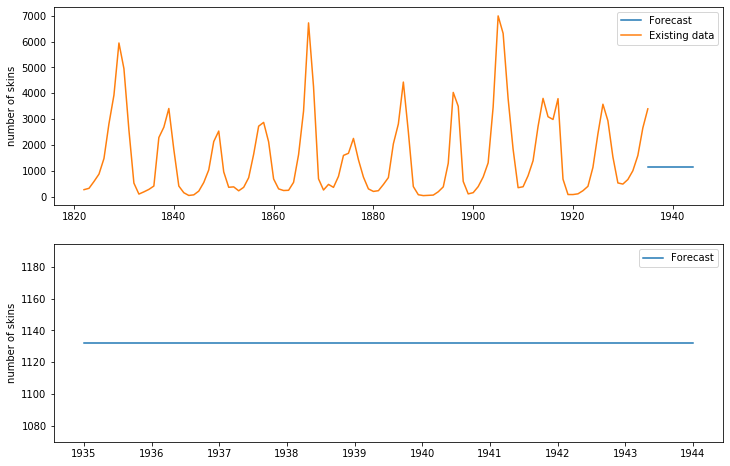

In [301]:
horizon = 10

# fit arima model to whole time series
big_cats_log = np.log(big_cats)
arima_model.fit(big_cats)

#make predictions for following 12 periods
final_forecast = naive1.predict(horizon)

#create an datetime index for the forecast horizon
forecast_index = pd.date_range(start='1935', periods=horizon, freq='YS')

#plot the model with 90% predictions intervals
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(pd.Series(final_forecast, index=forecast_index));
axes[0].plot(big_cats)


axes[0].set(ylabel='number of skins');

axes[0].legend([ 'Forecast','Existing data', '95% PI']);



axes[1].plot(pd.Series(final_forecast, index=forecast_index));
axes[1].set(ylabel='number of skins');


axes[1].legend(['Forecast', '95% PI']);

## Seasonal naive

In [320]:
snf = SNaive(period=period)
snf.fit(train)
insample_predictions = snf.fittedvalues

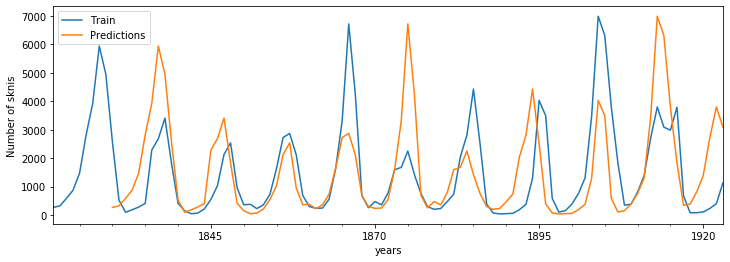

In [321]:
ax = train.plot(figsize=(12,4))
insample_predictions.plot(ax=ax)
ax.set(xlabel='years', ylabel='Number of sknis');
ax.legend(['Train', 'Predictions']);

In [322]:
mean_absolute_percentage_error(big_cats[period:], insample_predictions[period:])

170.68635213081245

In [84]:
period = 10

#i've written a function to help with the cv of the baseline
from forecast.model_selection import time_series_cv

#it requires the data to be split into training and validation.
train, test = ts_train_test_split(big_cats_log, '1960-01-01')

trainCV, valCV = train.iloc[:len(train)//3], train.iloc[len(train)//3:]

snf = SNaive(period=period)

cv_scores = time_series_cv(snf, 
                           error_func=mean_absolute_percentage_error,
                           train=trainCV,
                           val=valCV,
                           horizons=[10],
                           step=10)

In [85]:
cv_scores = pd.DataFrame(cv_scores)
cv_scores.describe()

0
count   7.000000
mean   14.909910
std     7.785939
min     7.748523
25%     9.508099
50%    12.492520
75%    17.512322
max    30.087483

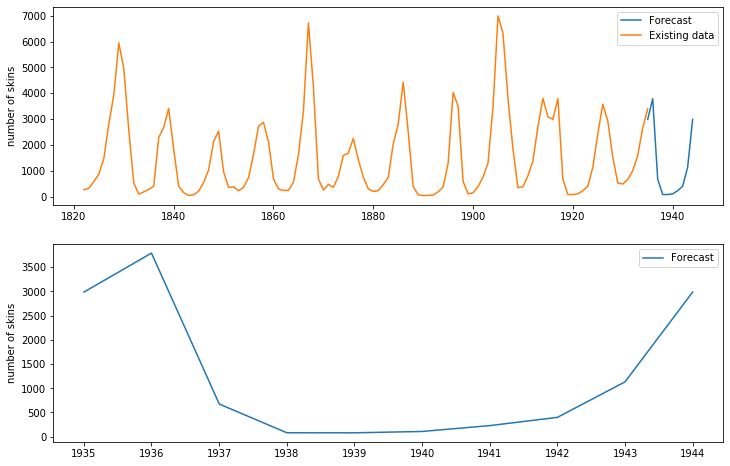

In [310]:
horizon = 10

#make predictions for following 12 periods
final_forecast = snf.predict(horizon)

#create an datetime index for the forecast horizon
forecast_index = pd.date_range(start='1935', periods=horizon, freq='YS')

#plot the model with 90% predictions intervals
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(pd.Series(final_forecast, index=forecast_index));
axes[0].plot(big_cats)


axes[0].set(ylabel='number of skins');

axes[0].legend([ 'Forecast','Existing data', '95% PI']);



axes[1].plot(pd.Series(final_forecast, index=forecast_index));
axes[1].set(ylabel='number of skins');


axes[1].legend(['Forecast', '95% PI']);

# ACF PACF

/home/campus-5/anaconda3/envs/forecast/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


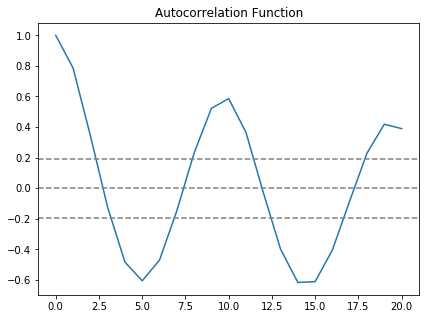

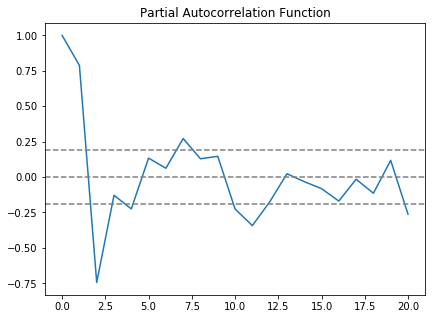

<Figure size 1080x360 with 0 Axes>

In [242]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(train_log, nlags=20)
lag_pacf = pacf(train_log, nlags=20, method='ols')
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()
plt.tight_layout()